In [ ]:
#Reading libraries for fall detection
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow

In [ ]:
#Creating JSON environment for fall detection dataset reading
api_token = {"username":"umersabir","key":"f9baa2c66c22383ffce5102ddda9d051"}
import json
import zipfile
import os
!mkdir .kaggle

In [ ]:
#Google environment for fall detection  dataset reading
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"umersabir","key":"2f30e2a9af17bd8d6186a46897b4e976"}'}

In [1]:
#kaggle environment for fall detection  dataset reading
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Reading fall detection dataset
!kaggle datasets download -d uttejkumarkandagatla/fall-detection-dataset

 99% 107M/108M [00:06<00:00, 22.3MB/s]
100% 108M/108M [00:06<00:00, 18.6MB/s]


In [ ]:
!unzip '*.zip'

In [ ]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
base_skin_dir = os.path.join('')

# Merging images from both folders fall and not fall

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'fall': 'Fall Images',
    'not fall': 'Not fall images'
}

In [ ]:
#fall detection dataset
fall_df = pd.read_csv(os.path.join(base_skin_dir, 'fallLabels.csv'))


In [ ]:
#fall detection dataset train-test
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.30,random_state=42)

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
from keras.initializers import glorot_uniform
# Set the CNN model
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(filters = 16 , kernel_size = (3,3) , strides = (1,1) , activation='relu', padding = "valid" , kernel_initializer=glorot_uniform(seed = 2),input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 32 , kernel_size = (4,4) , strides = (2,2) , activation='relu',  padding = "valid" , kernel_initializer=glorot_uniform(seed = 2)))
model.add(MaxPool2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64 , kernel_size = (3,3) , strides = (2,2) , activation='relu',  padding = "valid" , kernel_initializer = glorot_uniform(seed = 2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128 , kernel_size = (3,3) , strides = (1,1) , activation='relu', padding = "valid" , kernel_initializer = glorot_uniform()))
model.add(MaxPool2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model.add(Conv2D(filters = 256 , kernel_size = (2,2) , strides = (2,2) , activation='relu', padding = "valid" , kernel_initializer = glorot_uniform()))
#model.add(AveragePooling2D(pool_size = (3,3) , strides = (1,1) , padding = "valid"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 73, 98, 16)        448       
_________________________________________________________________
dropout_19 (Dropout)         (None, 73, 98, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 35, 48, 32)        8224      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 24, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 17, 24, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 11, 64)         18496     
_________________________________________________________________
dropout_21 (Dropout)         (None, 8, 11, 64)        

In [ ]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
keras.applications.NASNetMobile(
    input_shape=None,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [ ]:
keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [ ]:
keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [ ]:
keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [ ]:
keras.applications.EfficientNetB4(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs
)

In [ ]:
# Fit the model
epochs = 50
batch_size = 20
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
#model.save("model.h5")

In [ ]:
plot_model_history(history)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)



# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

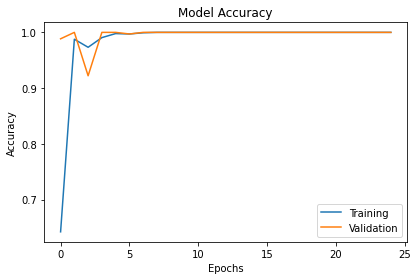

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training','Validation'], loc='lower right')
plt.tight_layout()
plt.rcParams.update({'font.size': 18})
plt.savefig('training & validation accuracyPepperBellLeaf.pdf',  dpi=1000,bbox_inches='tight')
files.download('training & validation accuracyPepperBellLeaf.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

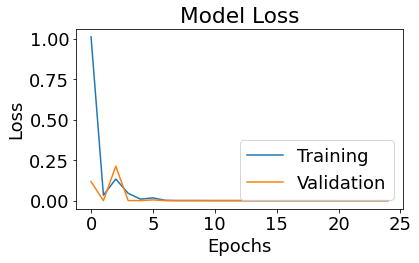

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Training','Validation'], loc='lower right')
plt.tight_layout()
plt.rcParams.update({'font.size': 18})
plt.savefig('training & validation accuracyPepperBellLeaf.pdf',  dpi=1000,bbox_inches='tight')
files.download('training & validation accuracyPepperBellLeaf.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

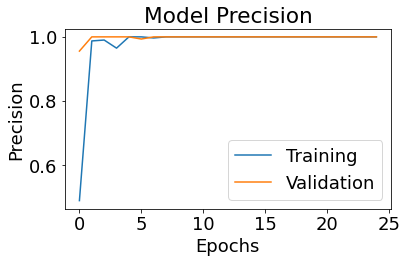

In [ ]:
plt.plot(history.history["precision"])
plt.plot(history.history["val_precision"])
plt.title("Model Precision")
plt.ylabel("Precision")
plt.xlabel("Epochs")
plt.legend(['Training','Validation'], loc='lower right')
plt.tight_layout()
plt.rcParams.update({'font.size': 18})
plt.savefig('training & validation precisionPepperBellLeaf.pdf',  dpi=1000,bbox_inches='tight')
files.download('training & validation precisionPepperBellLeaf.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

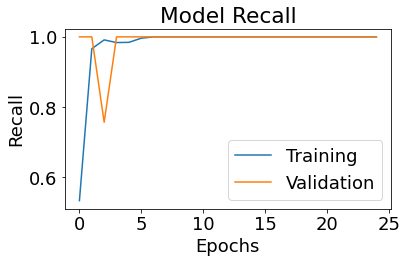

In [ ]:
plt.plot(history.history["recall"])
plt.plot(history.history["val_recall"])
plt.title("Model Recall")
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.legend(['Training','Validation'], loc='lower right')
plt.tight_layout()
plt.rcParams.update({'font.size': 18})
plt.savefig('training & validation recallPepperBellLeaf.pdf',  dpi=1000,bbox_inches='tight')
files.download('training & validation recallPepperBellLeaf.pdf')
plt.show()

In [ ]:
!pip install -q keras_metrics
import keras_metrics